# DSCI D 699 Independent Study in Data Science Fall 2018

## Advisor: Professor David Crandall

Author: Aniruddha M Godbole


In this notebook we use use the undisputed complaints for the three types of loans (mortgage loans, payday loans, student loans), use our classification of loans (and not the CFPB classification) and use a heuristic to iteratively find the topics (the iterations were done manually and in this notebook the stop words from the fourth iteration have been used) in the case of each of the three loans. The same stop words have been used for all three types of loans. Only NOUNS have been used (as seen in my experimentation and also reported in prior literature---citation in the Report). Finally, the three HDP topic models are saved (also dictionaries have been saved).

In [1]:
import os
import csv
import pandas as pd

complaints_pathname='./complaints_data/Consumer_Complaints.csv'
df_all_complaints=pd.read_csv(complaints_pathname)

In [2]:
complaints_pathname='./complaints_data/Consumer_Complaints.csv'
df_all_complaints=pd.read_csv(complaints_pathname)

In [3]:
print('The total number of complaints in the dataset is ', df_all_complaints.shape[0])

The total number of complaints in the dataset is  1087269


In [4]:
 df_all_complaints.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [5]:
df_all_narr=df_all_complaints.dropna(subset=['Consumer complaint narrative'])
df_all_undisp_narr=df_all_narr.loc[df_all_narr['Consumer disputed?']=='No']

In [6]:
print('The total number of complaints with narrative in the dataset is ', df_all_narr.shape[0])
print('The total number of complaints with narrative--- and where response is undisputed by customer--- in the dataset is ', df_all_undisp_narr.shape[0])

The total number of complaints with narrative in the dataset is  307120
The total number of complaints with narrative--- and where response is undisputed by customer--- in the dataset is  128314


The choice on only selecting complaints where response is undisputed by the customer can help look at more genuine of the complaints (that's the assumption) and it's a practical choice given that tokenization using the spaCy library required the text to be limited to a million words.

In [7]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html

dfmort1=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Mortgage'].loc[df_all_undisp_narr['Sub-product']=='Conventional home mortgage']
dfmort2=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Mortgage'].loc[df_all_undisp_narr['Sub-product']=='Conventional fixed mortgage']
dfmort3=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Mortgage'].loc[df_all_undisp_narr['Sub-product']=='Conventional adjustable mortgage (ARM)']
dfmort4=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Mortgage']
dfmort5=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Mortgage debt']

dfmortprod=pd.concat([dfmort1,dfmort2,dfmort3],ignore_index=True)
dfmortprod_cos=set(dfmortprod['Company'])

dfmortdebtcoll=pd.concat([dfmort4,dfmort5],ignore_index=True)
dfmortdebtcoll_cos=set(dfmortdebtcoll['Company'])

dfmortproddebtcollboth_cos=set.intersection(dfmortprod_cos,dfmortdebtcoll_cos)

print('The number of companies associated with mortgage product---undisputed complaints with narrative-- :',len(dfmortprod_cos))
print('The number of companies associated with mortgage debt collection---undisputed complaints with narrative-- :',len(dfmortdebtcoll_cos))
print('The number of companies associated with mortgage product AND mortagage debt collection---undisputed complaints with narrative-- :',len(dfmortproddebtcollboth_cos))

The number of companies associated with mortgage product---undisputed complaints with narrative-- : 462
The number of companies associated with mortgage debt collection---undisputed complaints with narrative-- : 129
The number of companies associated with mortgage product AND mortagage debt collection---undisputed complaints with narrative-- : 76


As only 76 out of the 462 i.e. 16% of the product companies are involved in both mortgage product and mortgage debt collection.

In [8]:
dfmortprod.shape

(14667, 18)

In [9]:
dfmortproddebtcollboth_cos

{'21ST MORTGAGE CORP.',
 'ARVEST BANK GROUP, INC.',
 'ASSOCIATED BANK, NATIONAL ASSOCIATION',
 'Aldridge Pite, LLP',
 'Altisource Portfolio Solutions, S.à r.l.',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'BAYVIEW LOAN SERVICING, LLC',
 'BB&T CORPORATION',
 'BMO HARRIS BANK NATIONAL ASSOCIATION',
 'BOK FINANCIAL CORP',
 'Brock & Scott, PLLC',
 'CAPITAL ONE FINANCIAL CORPORATION',
 'CARRINGTON MORTGAGE SERVICES, LLC',
 'CIT BANK, NATIONAL ASSOCIATION',
 'CITIBANK, N.A.',
 'CITIZENS FINANCIAL GROUP, INC.',
 'Ditech Financial LLC',
 "Dyck-O'Neal, Inc.",
 'FAIR COLLECTIONS & OUTSOURCING, INC.',
 'FIRST CITIZENS BANCSHARES, INC.',
 'FIRST TENNESSEE BANK NATIONAL ASSOCIATION',
 'FLAGSTAR BANK, FSB',
 'Fay Servicing, LLC',
 'Fidelity National Financial, Inc',
 'Franklin Credit Management Corporation',
 'Gross Polowy LLC',
 'HOMEBRIDGE FINANCIAL SERVICES, INC.',
 'HSBC NORTH AMERICA HOLDINGS INC.',
 'Harmon Law Offices, P.C.',
 'JPMORGAN CHASE & CO.',
 'James E. Albertelli, P.A., a Florida pro

In [10]:
dfmortproddebtcoll=pd.concat([dfmort1,dfmort2,dfmort3,dfmort4,dfmort5],ignore_index=True)

In [11]:
#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
dfmortproddebtcoll_common_cos=dfmortproddebtcoll.loc[dfmortproddebtcoll['Company'].isin(dfmortproddebtcollboth_cos)]

In [12]:
dfmortproddebtcoll_common_cos['Company'].nunique()

76

# We will use dfmortproddebtcoll_common_cos

In [13]:
dfpay1=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Payday loan']
dfpay2=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Payday loan']
dfpay3=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Payday loan debt']

dfpayprod_cos=set(dfpay1['Company'])

dfpaydebtcoll=pd.concat([dfpay2,dfpay3],ignore_index=True)
dfpaydebtcoll_cos=set(dfpaydebtcoll['Company'])

dfpayproddebtcollboth_cos=set.intersection(dfpayprod_cos,dfpaydebtcoll_cos)

print('The number of companies associated with payday loan product---undisputed complaints with narrative-- :',len(dfpayprod_cos))
print('The number of companies associated with payday loan debt collection---undisputed complaints with narrative-- :',len(dfpaydebtcoll_cos))
print('The number of companies associated with payday loan product AND payday loan debt collection---undisputed complaints with narrative-- :',len(dfpayproddebtcollboth_cos))


The number of companies associated with payday loan product---undisputed complaints with narrative-- : 243
The number of companies associated with payday loan debt collection---undisputed complaints with narrative-- : 359
The number of companies associated with payday loan product AND payday loan debt collection---undisputed complaints with narrative-- : 147


As 147 out of the 243 i.e. 60% of the product companies are involved in both payday loan product and payday loan debt collection
its best to consider the 147 companies involved in both the product and debt collection.

In [14]:
dfpayproddebtcoll=pd.concat([dfpay1,dfpay2,dfpay3],ignore_index=True)

In [15]:
#https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
dfpayproddebtcoll_common_cos=dfpayproddebtcoll.loc[dfpayproddebtcoll['Company'].isin(dfpayproddebtcollboth_cos)]

In [16]:
dfpayproddebtcoll_common_cos['Company'].nunique()

147

In [17]:
dfpayproddebtcoll_common_cos.shape

(2698, 18)

In [18]:
dfpayproddebtcollboth_cos

{'2233 Paradise Road LLC',
 '2288984 Ontario Inc.',
 'ACE CASH EXPRESS, INC.',
 'ACH Recovery Solutions',
 'ACQ Holdings, LLC.',
 'ADR ARBITRATION SERVICES (Closed)',
 'Acceptance Solutions Group, INC',
 'Ad Astra Recovery Services Inc',
 'Advance America, Cash Advance Centers, Inc.',
 'Alliant Capital Management LLC',
 'Allied Collection Services, Inc. (Nevada)',
 'AmeriCash Holding LLC',
 'American Credit Financial',
 'American Credit Resolution, Incorporated',
 'Amscot Corporation',
 'Avant Credit Corporation',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'Big Picture Loans, LLC',
 'Bliksum, LLC',
 'BlueChip Financial',
 'Blueshore Recovery',
 'Bronstein & Weiss Arbitration',
 'Brookshaw Management, LLC',
 'Bryant Bryant & Associates LLC',
 'CAPITAL ONE FINANCIAL CORPORATION',
 'CASH AMERICA INTERNATIONAL, INC.',
 'CASHCALL, INC.',
 'CHECK INTO CASH INC.',
 'CITIBANK, N.A.',
 'CNG FINANCIAL CORPORATION',
 'COMMUNITY CHOICE FINANCIAL, INC.',
 'CURO Intermediate Holdings',
 'Cash Expres

# We will use dfpayproddebtcoll_common_cos

In [19]:
dfstud1=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan servicing']
dfstud2=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Private student loan']
dfstud3=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Non-federal student loan']
dfstud4=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan']
dfstud5=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan debt']
dfstud6=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Non-federal student loan']
dfstud7=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Private student loan debt']

dfstudprod=pd.concat([dfstud1,dfstud2,dfstud3],ignore_index=True)
dfstudprod_cos=set(dfstudprod['Company'])

dfstuddebtcoll=pd.concat([dfstud4,dfstud5,dfstud6,dfstud7],ignore_index=True)
dfstuddebtcoll_cos=set(dfstuddebtcoll['Company'])


dfstudproddebtcollboth_cos=set.intersection(dfstudprod_cos,dfstuddebtcoll_cos)

print('The number of companies associated with Federal/Private Student loan product ---undisputed complaints with narrative-- :',len(dfstudprod_cos))
print('The number of companies associated with Federal/Private Student loan debt collection---undisputed complaints with narrative-- :',len(dfstuddebtcoll_cos))
print('The number of companies associated with Federal/Private student loan product AND Federal/Private student loan debt collection---undisputed complaints with narrative-- :',len(dfstudproddebtcollboth_cos))


dfstudprodfed=pd.concat([dfstud1],ignore_index=True)
dfstudprodpvt=pd.concat([dfstud2,dfstud3],ignore_index=True)
print('The number of companies associated with Federal student loan product, Private student loan product and both are:',len(set(dfstudprodfed['Company'])),len(set(dfstudprodpvt['Company'])),len(set.intersection(set(dfstudprodfed['Company']),set(dfstudprodpvt['Company']))))

dfstuddebtcollfed=pd.concat([dfstud4,dfstud5],ignore_index=True)
dfstuddebtcollpvt=pd.concat([dfstud6,dfstud7],ignore_index=True)
print('The number of companies associated with Federal student loan debt collection, Private student loan debt collection and both are:',len(set(dfstuddebtcollfed['Company'])),len(set(dfstuddebtcollpvt['Company'])),len(set.intersection(set(dfstuddebtcollfed['Company']),set(dfstuddebtcollpvt['Company']))))

dffedpvtstudproddebtcoll_cos=set.intersection(set.intersection(set(dfstudprodfed['Company']),set(dfstudprodpvt['Company'])),set.intersection(set(dfstuddebtcollfed['Company']),set(dfstuddebtcollpvt['Company'])))
print('The number of companies associated with Federal Student loan product, Private Student loan product, Federal Student loan debt collection and Private Student loan debt collection are:',len(dffedpvtstudproddebtcoll_cos))

The number of companies associated with Federal/Private Student loan product ---undisputed complaints with narrative-- : 221
The number of companies associated with Federal/Private Student loan debt collection---undisputed complaints with narrative-- : 192
The number of companies associated with Federal/Private student loan product AND Federal/Private student loan debt collection---undisputed complaints with narrative-- : 107
The number of companies associated with Federal student loan product, Private student loan product and both are: 126 165 70
The number of companies associated with Federal student loan debt collection, Private student loan debt collection and both are: 92 154 54
The number of companies associated with Federal Student loan product, Private Student loan product, Federal Student loan debt collection and Private Student loan debt collection are: 36


In [20]:
dffedpvtstudproddebtcoll_cos

{'ACS Education Services',
 'AES/PHEAA',
 'Account Control Technology, Inc.',
 'Allied Interstate LLC',
 'Alorica Inc.',
 'CITIBANK, N.A.',
 'CITIZENS FINANCIAL GROUP, INC.',
 'COAST PROFESSIONAL INC',
 'Collection Technology Incorporated',
 'ConServe',
 'Delta Management Associates, Inc.',
 'ECMC Group, Inc.',
 'EOS Holdings, Inc.',
 'FINANCIAL ASSET MANAGEMENT SYSTEMS INC',
 'Firstsource Business Process Services, LLC',
 'GC Services Limited Partnership',
 'GREAT LAKES',
 'HEARTLAND PAYMENT SYSTEMS INC',
 'HIGHER EDUCATION STUDENT ASSISTANCE AUTHORITY (HESAA)',
 'Immediate Credit Recovery',
 'MOHELA',
 'NELNET, INC.',
 'National Enterprise Systems, Inc.',
 'Navient Solutions, LLC.',
 'Performant Financial Corporation',
 'SLM CORPORATION',
 'TRANSWORLD SYSTEMS INC',
 'Texas Guaranteed',
 'The CBE Group, Inc.',
 'URS Holding, LLC',
 'United Student Aid (USA) Funds',
 'Utah System of Higher Education',
 'Van Ru Credit Corporation',
 'WELLS FARGO & COMPANY',
 'Williams & Fudge, Inc',
 'W

In [21]:
dfstud1=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan servicing']
#dfstud2=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Private student loan']
#dfstud3=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Student loan'].loc[df_all_undisp_narr['Sub-product']=='Non-federal student loan']
dfstud4=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan']
dfstud5=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Federal student loan debt']
#dfstud6=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Non-federal student loan']
#dfstud7=df_all_undisp_narr.loc[df_all_undisp_narr['Product']=='Debt collection'].loc[df_all_undisp_narr['Sub-product']=='Private student loan debt']

dffedstudprod=pd.concat([dfstud1],ignore_index=True)
dffedstudprod_cos=set(dfstudprod['Company'])

dffedstuddebtcoll=pd.concat([dfstud4,dfstud5],ignore_index=True)
dffedstuddebtcoll_cos=set(dfstuddebtcoll['Company'])


dffedstudproddebtcollboth_cos=set.intersection(dffedstudprod_cos,dffedstuddebtcoll_cos)

print('The number of companies associated with Federal Student loan product ---undisputed complaints with narrative-- :',len(dffedstudprod_cos))
print('The number of companies associated with Federal Student loan debt collection---undisputed complaints with narrative-- :',len(dffedstuddebtcoll_cos))
print('The number of companies associated with Federal student loan product AND Federal student loan debt collection---undisputed complaints with narrative-- :',len(dffedstudproddebtcollboth_cos))

The number of companies associated with Federal Student loan product ---undisputed complaints with narrative-- : 221
The number of companies associated with Federal Student loan debt collection---undisputed complaints with narrative-- : 192
The number of companies associated with Federal student loan product AND Federal student loan debt collection---undisputed complaints with narrative-- : 107


In [22]:
dffedstudproddebtcollboth_cos

{'ACCESS GROUP INC.',
 'ACS Education Services',
 'AES/PHEAA',
 'ATG Credit, LLC',
 'Ability Recovery Services, LLC',
 'Account Control Technology, Inc.',
 'Action Financial Services, LLC',
 'Allied International Credit Corp., (US)',
 'Allied Interstate LLC',
 'Alorica Inc.',
 'Asset Recovery Solutions, LLC',
 'Automated Collection Services, Inc.',
 'BANK OF AMERICA, NATIONAL ASSOCIATION',
 'BRAZOS HIGHER EDUCATION AUTHORITY, INC.',
 'Brelvis Consulting, LLC',
 'CITIBANK, N.A.',
 'CITIZENS FINANCIAL GROUP, INC.',
 'CL HOLDINGS LLC',
 'COAST PROFESSIONAL INC',
 'Capital Management Services, LP',
 'Ceannate',
 'Collection Technology Incorporated',
 'College Assist',
 'ConServe',
 'D. SCOTT CARRUTHERS',
 'DISCOVER BANK',
 'Delta Management Associates, Inc.',
 'Deutsche Bank',
 'Diversified Consultants, Inc.',
 'Dream Center Education Holdings',
 'ECMC Group, Inc.',
 'EOS Holdings, Inc.',
 'ERC',
 'Equitable Acceptance Corporation',
 'F.H. Cann & Associates, Inc.',
 'FINANCIAL ASSET MANAGE

In [23]:
dfstudproddebtcoll=pd.concat([dfstud1,dfstud2,dfstud3,dfstud4,dfstud5,dfstud6,dfstud7],ignore_index=True)

In [24]:
dfstudproddebtcoll_common_cos=dfstudproddebtcoll.loc[dfstudproddebtcoll['Company'].isin(dffedpvtstudproddebtcoll_cos)]

In [25]:
dfstudproddebtcoll_common_cos['Company'].nunique()

36

#  We will use dfstudproddebtcoll_common_cos

In [26]:
dfmortproddebtcoll_common_cos['Consumer complaint narrative'].sample(frac=0.05,replace=False,random_state=0).to_csv('mortgage_comp_narrative.txt',encoding='utf-8')
dfpayproddebtcoll_common_cos['Consumer complaint narrative'].sample(frac=0.45,replace=False,random_state=0).to_csv('payday_comp_narrative.txt',encoding='utf-8')
dfstudproddebtcoll_common_cos['Consumer complaint narrative'].sample(frac=0.10,replace=False,random_state=0).to_csv('student_comp_narrative.txt',encoding='utf-8')

In [27]:
#https://github.com/bhargavvader/personal/blob/master/notebooks/text_analysis_tutorial/topic_modelling.ipynb
#https://www.youtube.com/watch?v=ZkAFJwi-G98
import spacy
nlp = spacy.load('en_core_web_sm')

In [28]:
#my_stop_words=[u'bank',u'payment',u'loan',u'go',u'i',u'from',u'my',u'saying',u'download',u'being',u'info',u'XXXX',u'pay',u'student',u'company',u'account',u'paying',u'loans',u'payments',u'I',u'mortgage',u'the',u'home',u'house',u'property',u'We',u'The',u'XX',u'because',u'Bank',u'America',u'Wells',u'Fargo',u'They',u"n't",u'$',u'time',u'told',u'\n\n',u'  ',u'As',u'money',u'debt',u'he',u'day',u'work',u'said',u'called',u'calls',u'phone',u'number',u'He',u'payday',u'Mae',u'Sallie',u'month',u'debt',u'receive',u'pay',u'go',u'send',u'ask',u'sell',u'borrower',u'facility',u'time',u'year',u'month',u'robo',u'middle',u'check']  #v0.1
#my_stop_words=[u'bank',u'payment',u'loan',u'go',u'i',u'from',u'my',u'saying',u'download',u'being',u'info',u'XXXX',u'pay',u'student',u'company',u'account',u'paying',u'loans',u'payments',u'I',u'mortgage',u'the',u'home',u'house',u'property',u'We',u'The',u'XX',u'because',u'Bank',u'America',u'Wells',u'Fargo',u'They',u"n't",u'$',u'time',u'told',u'\n\n',u'  ',u'As',u'money',u'debt',u'he',u'day',u'work',u'said',u'called',u'calls',u'phone',u'number',u'He',u'payday',u'Mae',u'Sallie',u'month',u'debt',u'receive',u'pay',u'go',u'send',u'ask',u'sell',u'borrower',u'facility',u'time',u'year',u'month',u'robo',u'middle',u'check',u'debt',u'daughter',u'week',u'year',u'session',u'pg',u'xxxxpage',u'mis',u'friend',u'credit',u'yard',u'human',u'citi',u'acre',u'someone',u'i.',u'chairman',u'name',u'manner',u'refer',u'corporation',u'grandmother',u'cc',u'cycle',u'people',u'girlfriend',u'onset',u'resource',
#u'preciousdriver',u'gal',u'man',u'daughter',u'georgia',u'agi',u'boundrie',u'set',u'thank',u'ed',u'bill',u'significance',u'bless',u'what',u'i',u'k',u'fedloan',u'hotel',u'crew',u'head',u'performer'] # v0.2
#my_stop_words=[u'bank',u'payment',u'loan',u'go',u'i',u'from',u'my',u'saying',u'download',u'being',u'info',u'XXXX',u'pay',u'student',u'company',u'account',u'paying',u'loans',u'payments',u'I',u'mortgage',u'the',u'home',u'house',u'property',u'We',u'The',u'XX',u'because',u'Bank',u'America',u'Wells',u'Fargo',u'They',u"n't",u'$',u'time',u'told',u'\n\n',u'  ',u'As',u'money',u'debt',u'he',u'day',u'work',u'said',u'called',u'calls',u'phone',u'number',u'He',u'payday',u'Mae',u'Sallie',u'month',u'debt',u'receive',u'pay',u'go',u'send',u'ask',u'sell',u'borrower',u'facility',u'time',u'year',u'month',u'robo',u'middle',u'check',u'debt',u'daughter',u'week',u'year',u'session',u'pg',u'xxxxpage',u'mis',u'friend',u'credit',u'yard',u'human',u'citi',u'acre',u'someone',u'i.',u'chairman',u'name',u'manner',u'refer',u'corporation',u'grandmother',u'cc',u'cycle',u'people',u'girlfriend',u'onset',u'resource',
#u'preciousdriver',u'gal',u'man',u'daughter',u'georgia',u'agi',u'boundrie',u'set',u'thank',u'ed',u'bill',u'significance',u'bless',u'what',u'i',u'k',u'fedloan',u'hotel',u'crew',u'head',u'performer',u'c.',u'bofa.',u'hail',u'agent',u'me.all',u'that:1.1',u'crystal',u'statusdespite',u'layer',
#u'hr',u'midst',u'absence',u'situation',u'error',u'modification',u'loss!?!?!?!.',u'doing',u'grandmother',u'retirement',u'st',u'husband',u'sir',u'girl',u'what',u'i',u'lady',u'claiming',
#u'senior',u'colleague',u'birth',u'use',u'drafting',u'sake',u'red',u'path',u'navient',u'yrs',u'xxxxgreatlake',u'ring',u'thousand',u'dog',u'd',u'definite'] # v0.3

#my_stop_words=[u'bank',u'payment',u'loan',u'go',u'i',u'from',u'my',u'saying',u'download',u'being',u'info',u'XXXX',u'pay',u'student',u'company',u'account',u'paying',u'loans',u'payments',u'I',u'mortgage',u'the',u'home',u'house',u'property',u'We',u'The',u'XX',u'because',u'Bank',u'America',u'Wells',u'Fargo',u'They',u"n't",u'$',u'time',u'told',u'\n\n',u'  ',u'As',u'money',u'debt',u'he',u'day',u'work',u'said',u'called',u'calls',u'phone',u'number',u'He',u'payday',u'Mae',u'Sallie',u'month',u'debt',u'receive',u'pay',u'go',u'send',u'ask',u'sell',u'borrower',u'facility',u'time',u'year',u'month',u'robo',u'middle',u'check',u'debt',u'daughter',u'week',u'year',u'session',u'pg',u'xxxxpage',u'mis',u'friend',u'credit',u'yard',u'human',u'citi',u'acre',u'someone',u'i.',u'chairman',u'name',u'manner',u'refer',u'corporation',u'grandmother',u'cc',u'cycle',u'people',u'girlfriend',u'onset',u'resource',
#u'preciousdriver',u'gal',u'man',u'daughter',u'georgia',u'agi',u'boundrie',u'set',u'thank',u'ed',u'bill',u'significance',u'bless',u'what',u'i',u'k',u'fedloan',u'hotel',u'crew',u'head',u'performer',u'c.',u'bofa.',u'hail',u'agent',u'me.all',u'that:1.1',u'crystal',u'statusdespite',u'layer',u'hr',u'midst',u'absence',u'situation',u'error',u'modification',u'loss!?!?!?!.',u'doing',u'grandmother',u'retirement',u'st',u'husband',u'sir',u'girl',u'what',u'i',u'lady',u'claiming',
#u'senior',u'colleague',u'birth',u'use',u'drafting',u'sake',u'red',u'path',u'navient',u'yrs',u'xxxxgreatlake',u'ring',u'thousand',u'dog',u'd',u'definite',u'minus',u'bofa.',u'co.',u'speaker',u'head',u'difference',u'box',u'sewer',u'spart',u'loan/',u'init',u'service',u'director',u'boss',u'site',u'means',u'est',u'brother',u'hundred',u'kin',u'noon',u'yesterday',u'essential',u'avenue',u'tomorrow',u'sent',u'whom',u'slrp',u'female',u'since',u'brotherinlaws',u'page',u'usefuleness'] # v0.4

my_stop_words=[u'bank',u'payment',u'loan',u'go',u'i',u'from',u'my',u'saying',u'download',u'being',u'info',u'XXXX',u'pay',u'student',u'company',u'account',u'paying',u'loans',u'payments',u'I',u'mortgage',u'the',u'home',u'house',u'property',u'We',u'The',u'XX',u'because',u'Bank',u'America',u'Wells',u'Fargo',u'They',u"n't",u'$',u'time',u'told',u'\n\n',u'  ',u'As',u'money',u'debt',u'he',u'day',u'work',u'said',u'called',u'calls',u'phone',u'number',u'He',u'payday',u'Mae',u'Sallie',u'month',u'debt',u'receive',u'pay',u'go',u'send',u'ask',u'sell',u'borrower',u'facility',u'time',u'year',u'month',u'robo',u'middle',u'check',u'debt',u'daughter',u'week',u'year',u'session',u'pg',u'xxxxpage',u'mis',u'friend',u'credit',u'yard',u'human',u'citi',u'acre',u'someone',u'i.',u'chairman',u'name',u'manner',u'refer',u'corporation',u'grandmother',u'cc',u'cycle',u'people',u'girlfriend',u'onset',u'resource',
u'preciousdriver',u'gal',u'man',u'daughter',u'georgia',u'agi',u'boundrie',u'set',u'thank',u'ed',u'bill',u'significance',u'bless',u'what',u'i',u'k',u'fedloan',u'hotel',u'crew',u'head',u'performer',u'c.',u'bofa.',u'hail',u'agent',u'me.all',u'that:1.1',u'crystal',u'statusdespite',u'layer',u'hr',u'midst',u'absence',u'situation',u'error',u'modification',u'loss!?!?!?!.',u'doing',u'grandmother',u'retirement',u'st',u'husband',u'sir',u'girl',u'what',u'i',u'lady',u'claiming',u'senior',u'colleague',u'birth',u'use',u'drafting',u'sake',u'red',u'path',u'navient',u'yrs',u'xxxxgreatlake',u'ring',u'thousand',u'dog',u'd',u'definite',u'minus',u'bofa.',u'co.',u'speaker',u'head',u'difference',u'box',u'sewer',u'spart',u'loan/',u'init',u'service',u'director',u'boss',u'site',u'means',u'est',u'brother',u'hundred',u'kin',u'noon',u'yesterday',u'essential',u'avenue',u'tomorrow',u'sent',u'whom',u'slrp',u'female',u'since',u'brotherinlaws',u'page',u'usefuleness',u'trid',u'purple',u'tid',u'elbow',u'lilac',u'circuit',u'sending',u'abbreviation',u'woman',
u'door',u'name',u'because',u'weekend',u'wk',u'basic',u'thing',u'rank',u'navient',u'someone',u'48hrs',u'dinner',u'it',u'me',u'progress',u'member',u'dismiss'] # v0.5



for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [29]:
file_payday='payday_comp_narrative.txt'
f=open(file_payday,'r',encoding='utf-8')
payday_text=f.read()
f.close()


file_student='student_comp_narrative.txt'
f=open(file_student,'r',encoding='utf-8')
student_text=f.read()
f.close()

file_mortgage='mortgage_comp_narrative.txt'
f=open(file_mortgage,'r',encoding='utf-8')
mortgage_text=f.read()
f.close()

In [30]:
doc_payday=nlp(payday_text)

In [31]:
doc_student=nlp(student_text)

In [32]:
doc_mortgage=nlp(mortgage_text)

In [33]:
common_pos_list=['NOUN'] #['NOUN','ADJ','VERB','ADV'] #['NOUN','ADJ']

In [34]:
payday_pos_list=common_pos_list

payday_preproc_text=[]
payday_preproc_sent=[]

for token in doc_payday:
    if token.text!='\n':
        if not(token.is_stop) and not(token.is_punct) and token.pos_ in payday_pos_list:
            #payday_preproc_sent.append(token.text)
            payday_preproc_sent.append(token.lemma_)
    else:
        payday_preproc_text.append(payday_preproc_sent)
        payday_preproc_sent=[]

payday_preproc_text.append(payday_preproc_sent) #last sentence

print(payday_preproc_text)

[['place', 'charge', 'attorney', 'bankruptcy', 'attorney', 'bankruptcy', 'attorney', 'monthsxx', 'datexx', 'datexx', 'datexx', 'place', 'calling', 'person', 'address', 'validation', 'letter', 'mail', 'somebody'], ['collection', 'time', 'time', 'check', 'email'], ['money', 'order', 'account', 'account', 'something', 'account', 'check', 'conduct'], ['recovery', 'system', 'collection', 'claim', 'report'], ['mo', 'installment', 'stuff', 'counter', 'care', 'paper', 'item', 'list', 'paper', 'dollar', 'son', 'fee', 'app', 'minute', 'dollar', 'dollar', 'day', 'right', 'night', 'cellphone', 'nerver', 'dirt', 'today', 'dollar'], ['victim', 'd', 'theft', 'report', 'day', 'frame', 'ad', 'number'], [], ['validation', 'signature', 'validity', 'debtand', 'claim', 'business', 'contract'], ['regard', 'today'], ['email', 'claim', 'wage'], [], ['warrant'], ['dealing', 'company', 'lender', 'collection', 'change', 'information'], ['email', 'office', 'email', 'time', 'row', 'job', 'message', 'office', 'offi

In [35]:
student_pos_list=common_pos_list

student_preproc_text=[]
student_preproc_sent=[]

for token in doc_student:
    if token.text!='\n':
        if not(token.is_stop) and not(token.is_punct) and token.pos_ in student_pos_list:
            #student_preproc_sent.append(token.text)
            student_preproc_sent.append(token.lemma_)
    else:
        student_preproc_text.append(student_preproc_sent)
        student_preproc_sent=[]

student_preproc_text.append(student_preproc_sent) #last sentence

print(student_preproc_text)

[['union', 'paper', 'copy', 'statement', 'penalty', 'fee', 'foresearance', 'tooth', 'word', 'help'], ['enrollment', 'school', 'program', 'email', 'school', 'enrollment', 'information', 'enrollment', 'school', 'fee', 'hardship'], ['t', 'amount'], ['deferment', 'request', 'bureau', 'company', 'report', 'impression', 'report', 'day', 'total', 'account', 'standard', 'admission', 'company'], ['contract', 'deferment', 'year', 'completion', 'school', 'residency', 'training', 'interest', 'lead', 'time', 'penalty', 'option'], ['income', 'base', 'denial', 'inability', 'family', 'tuition', 'child', 'difficulty', 'tuition', 'living', 'hardship', 'help', 'fir', 'help'], ['plan', 'yesterday', 'monitoring', 'day', 'account', 'result', 'score', 'drop', 'statement', 'today', 'gentleman', 'purpose', 'repayment', 'program', 'what', 'point'], ['job', 'provider', 'interest', 'rate', 'application', 'interest', 'rate', 'fee', 'addition', 'month', 'information', 'way', 'graduation', 'client', 'company', 'hard

In [36]:
mortgage_pos_list=common_pos_list

mortgage_preproc_text=[]
mortgage_preproc_sent=[]

for token in doc_mortgage:
    if token.text!='\n':
        if not(token.is_stop) and not(token.is_punct) and token.pos_ in mortgage_pos_list:
            #mortgage_preproc_sent.append(token.text)
            mortgage_preproc_sent.append(token.lemma_)
    else:
        mortgage_preproc_text.append(mortgage_preproc_sent)
        mortgage_preproc_sent=[]

mortgage_preproc_text.append(mortgage_preproc_sent) #last sentence

print(mortgage_preproc_text)

[['home', 'modification', 'servicer', 'investor', 'paperwork', 'month', 'trial', 'period', 'documentation', 'run', 'document', 'relationship', 'manager', 'manager', 'document', 'date', 'document', 'relationship', 'manager', 'document', 'trial', 'experience'], ['statement', 'delinquency', 'report', 'cash', 'flow', 'hand', 'proof', 'company', 'history', 'hand', 'addition', 'request', 'form', 'paper', 'principal', 'advantage', 'help'], ['thank'], ['water', 'line', 'sink', 'kitchen', 'claim', 'insurance', 'damage', 'servicer', 'loss', 'draft', 'escrow', 'fund', 'stage', 'completion', 'balance', 'value', 'loss', 'draft', 'beginning', 'direction', 'step', 'disbursement', 'conversation', 'representative', 'requirement', 'document', 'requirement', 'point', 'order', 'portion', 'fund', 'inspection', 'cost', 'refrigerator', 'washer', 'dryer', 'behavior', 'loss', 'draft', 'department', 'turn'], ['summon', 'retainer', 'information', 'sale', 'approval', 'denial', 'request', 'audit'], ['application']

In [37]:
import matplotlib.pyplot as plt
import gensim
import numpy as np

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now
%matplotlib inline

C:\Users\agodbole\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [38]:
payday_dictionary  = Dictionary(payday_preproc_text)
payday_corpus = [payday_dictionary.doc2bow(text) for text in payday_preproc_text]

In [39]:
student_dictionary  = Dictionary(student_preproc_text)
student_corpus = [student_dictionary.doc2bow(text) for text in student_preproc_text]

In [40]:
mortgage_dictionary  = Dictionary(mortgage_preproc_text)
mortgage_corpus = [mortgage_dictionary.doc2bow(text) for text in mortgage_preproc_text]

In [41]:
payday_hdpmodel = HdpModel(corpus=payday_corpus, id2word=payday_dictionary,random_state=0)
payday_hdpmodel.show_topics(num_topics=-1,num_words=7)

[(0,
  '0.005*rating + 0.005*item + 0.004*trap + 0.004*babysitter + 0.004*intend + 0.004*semantic + 0.003*loaning'),
 (1,
  '0.004*communicati + 0.004*samename + 0.003*theft + 0.003*system + 0.003*respond + 0.003*con + 0.003*fine'),
 (2,
  '0.004*notice + 0.004*spiral + 0.003*change + 0.003*office + 0.003*conversaation + 0.003*earth + 0.003*employer'),
 (3,
  '0.007*breach + 0.004*capital + 0.004*side + 0.004*script + 0.003*contract + 0.003*participant + 0.003*5min'),
 (4,
  '0.005*load + 0.004*breech + 0.004*monitoring + 0.004*boot + 0.004*laon + 0.003*processing + 0.003*ace'),
 (5,
  '0.005*waiting + 0.004*dial + 0.004*glitch + 0.004*proposal + 0.003*study + 0.003*resolveissue + 0.003*ground'),
 (6,
  '0.005*outsode + 0.004*day + 0.004*switch + 0.003*involvement + 0.003*defense + 0.003*possibility + 0.003*app'),
 (7,
  '0.004*hearing + 0.004*workplace + 0.004*goal + 0.003*social + 0.003*paper + 0.003*acceptance + 0.003*animal'),
 (8,
  '0.006*tention + 0.005*defendant + 0.005*detecti

# How to pick the best/coherent/frequent topics: the coherent metric doesn't seem to help...

In [42]:
student_hdpmodel = HdpModel(corpus=student_corpus, id2word=student_dictionary,random_state=0)
student_hdpmodel.show_topics(num_topics=-1,num_words=7)

[(0,
  '0.004*track + 0.003*school + 0.003*way + 0.003*wage + 0.003*transportation + 0.003*hospitalization + 0.003*police'),
 (1,
  '0.005*sample + 0.004*year + 0.004*form + 0.004*interest + 0.003*violation + 0.003*income + 0.003*forbearance'),
 (2,
  '0.004*hit + 0.004*balance + 0.003*program + 0.003*bubble + 0.003*research + 0.003*year + 0.003*negotiation'),
 (3,
  '0.004*minute + 0.003*38,"i + 0.003*payer + 0.003*world + 0.003*penny + 0.003*tax + 0.003*space'),
 (4,
  '0.004*formula + 0.004*undergrad + 0.004*electric + 0.003*gentleman + 0.003*specialist + 0.003*hotline + 0.003*submission'),
 (5,
  '0.003*period + 0.003*grant + 0.003*corp + 0.003*order + 0.003*lot + 0.003*managing + 0.003*man'),
 (6,
  '0.005*delinquent + 0.004*plus + 0.004*handling + 0.004*information + 0.003*attention + 0.003*transparency + 0.003*monie'),
 (7,
  '0.005*depressant + 0.005*point + 0.004*co + 0.004*institution + 0.004*length + 0.004*court + 0.003*cost'),
 (8,
  '0.004*justification + 0.003*wait + 0.00

In [43]:
mortgage_hdpmodel = HdpModel(corpus=mortgage_corpus, id2word=mortgage_dictionary,random_state=0)
mortgage_hdpmodel.show_topics(num_topics=-1,num_words=7)

[(0,
  '0.004*ditech + 0.003*tax + 0.003*ratio + 0.003*solicitation + 0.003*insurance + 0.003*core + 0.003*lender'),
 (1,
  '0.003*complaint + 0.003*mention + 0.003*document + 0.003*pass + 0.003*diferent + 0.003*cancellation + 0.003*letter'),
 (2,
  '0.003*offer + 0.003*deficit + 0.003*past + 0.003*affadivit + 0.003*city + 0.003*refinancing + 0.002*counting'),
 (3,
  '0.004*bill + 0.003*malice + 0.003*attitude + 0.003*decree + 0.003*flower + 0.003*person + 0.003*tier'),
 (4,
  '0.004*amendment + 0.004*request + 0.004*risk + 0.003*townhouse + 0.003*fashion + 0.003*employer + 0.003*disconnect'),
 (5,
  '0.006*thecontent + 0.003*repine + 0.003*expense + 0.003*chance + 0.003*medication + 0.003*nothing + 0.003*what'),
 (6,
  '0.003*serving + 0.003*block + 0.003*notice + 0.003*instrument + 0.003*pump + 0.003*maturity + 0.003*contrast'),
 (7,
  '0.005*document + 0.005*existence + 0.003*morthgae + 0.003*exchange + 0.003*search + 0.003*evict + 0.003*service'),
 (8,
  '0.003*hoa + 0.003*insuranc

In [44]:
#mortgage_hdpmodel.get_topics()

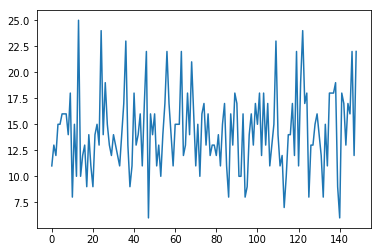

In [45]:
#https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work
mortgage_arr = np.argmax(mortgage_hdpmodel.get_topics(),axis=0)
y, x = np.histogram(mortgage_arr, bins=np.arange(150))
fig, ax = plt.subplots()
ax.plot(x[:-1], y)
fig.show()

# Looking at the most probable topic for each complaint and then plotting a frequency distribution does not help identify the key topics from the 150 topics.

In [46]:
mortgage_topic_infer=mortgage_hdpmodel.get_topics()

In [47]:
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.percentile.html
k_high_mortgage=np.percentile(mortgage_topic_infer,75) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
k_low_mortgage=np.percentile(mortgage_topic_infer,25) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
#print(k_low,k_high)

# The two outlier thresholds indicate values (beyond thresholds) that need to be ignored...else topic interpretability suffers as the probability of a topic due to specific compliants dominate...

In [48]:
mortgage_topic_infer_df=pd.DataFrame(mortgage_topic_infer)

In [49]:
mortgage_topic_infer_df

0         1         2         3         4         5         6     \
0    0.002327  0.000919  0.000303  0.000075  0.001445  0.001011  0.000472   
1    0.000405  0.002767  0.001791  0.000601  0.000331  0.000209  0.000526   
2    0.002202  0.000861  0.000524  0.000974  0.000376  0.000224  0.000180   
3    0.000813  0.001161  0.000342  0.000188  0.000240  0.001580  0.000144   
4    0.000198  0.000491  0.000348  0.000366  0.000717  0.000220  0.000117   
5    0.001654  0.001774  0.000583  0.000211  0.000180  0.000086  0.000802   
6    0.001745  0.001250  0.000404  0.000725  0.000041  0.001431  0.001080   
7    0.000227  0.004863  0.000161  0.000254  0.000548  0.000047  0.000536   
8    0.000053  0.000504  0.000503  0.000263  0.001092  0.000672  0.000593   
9    0.001758  0.000317  0.000215  0.000242  0.000202  0.000380  0.000297   
10   0.000662  0.002125  0.000826  0.000627  0.000350  0.000817  0.000346   
11   0.000373  0.000581  0.000681  0.000429  0.000144  0.000612  0.000578   
12   0.000201  0.001269  0.001100  0.000010  0.000295  0.000628  0.000024   
13   0.000249  0.000648  0.000077  0.000798  0.000578  0.000305  0.000205   
14   0.000752  0.000369  0.000498  0.000475  0.000296  0.000239  0.000103   
15   0.001293  0.000359  0.000898  0.001210  0.000593  0.000065  0.000495   
16   0.000982  0.000964  0.000189  0.000226  0.000368  0.000053  0.000519   
17   0.001347  0.001208  0.000305  0.000426  0.000504  0.000317  0.000199   
18   0.000826  0.000785  0.000078  0.000083  0.000051  0.000492  0.000358   
19   0.000106  0.000449  0.000059  0.001935  0.001118  0.000675  0.000297   
20   0.001183  0.000555  0.000234  0.000311  0.000094  0.000224  0.001921   
21   0.000612  0.001702  0.000733  0.000793  0.000411  0.001136  0.000072   
22   0.000019  0.000795  0.000317  0.000798  0.000674  0.000225  0.000362   
23   0.000519  0.000832  0.000300  0.000303  0.000331  0.000054  0.000275   
24   0.000392  0.000313  0.000195  0.000115  0.000493  0.000346  0.000321   
25   0.000569  0.000667  0.000458  0.000366  0.000260  0.000488  0.000281   
26   0.001092  0.000770  0.000344  0.000442  0.000118  0.000383  0.000050   
27   0.000221  0.000299  0.000050  0.000545  0.000230  0.000095  0.001602   
28   0.000660  0.000140  0.000183  0.000150  0.002849  0.000433  0.000417   
29   0.001075  0.000952  0.000119  0.000118  0.000370  0.000026  0.000059   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.000005  0.001004  0.000238  0.000537  0.000073  0.000134  0.000050   
121  0.000824  0.000982  0.001249  0.000049  0.001130  0.001207  0.002918   
122  0.000100  0.000363  0.000049  0.000294  0.000478  0.000750  0.000108   
123  0.000078  0.001243  0.001213  0.000222  0.000124  0.001156  0.000553   
124  0.000824  0.000569  0.000432  0.000250  0.000285  0.000567  0.000528   
125  0.000452  0.000795  0.000240  0.000573  0.001032  0.000046  0.000153   
126  0.000380  0.000104  0.000397  0.000154  0.000196  0.000901  0.000355   
127  0.000348  0.000369  0.000388  0.000029  0.000225  0.000474  0.000196   
128  0.000527  0.000501  0.000994  0.000711  0.000926  0.000254  0.000317   
129  0.000122  0.000307  0.000158  0.000186  0.000321  0.000177  0.001541   
130  0.000101  0.000690  0.000079  0.000078  0.000044  0.000018  0.000172   
131  0.000046  0.001747  0.000259  0.000050  0.001253  0.001590  0.000420   
132  0.000314  0.000126  0.000133  0.000932  0.000010  0.000083  0.000751   
133  0.000346  0.000889  0.000299  0.000053  0.000280  0.000200  0.000103   
134  0.000237  0.001100  0.000233  0.001521  0.000138  0.001397  0.000186   
135  0.002937  0.000318  0.000246  0.000033  0.000450  0.000065  0.000147   
136  0.000123  0.000123  0.001014  0.002258  0.000107  0.000663  0.000402   
137  0.001068  0.000124  0.001272  0.000438  0.000907  0.000012  0.000135   
138  0.000021  0.000420  0.000153  0.000468  0.000165  0.000371  0.001142   
139  0.000474  0.000326  0.000005  0.001123  0.000741  0.000218  0.000997   
140  

In [50]:
#https://stackoverflow.com/questions/43757977/replacing-values-greater-than-a-number-in-pandas-dataframe
mortgage_topic_infer_filter_df=mortgage_topic_infer_df.apply(lambda x: [y if (y > k_low_mortgage and y < k_high_mortgage) else 0 for y in x])

In [51]:
mortgage_topic_infer_filter_df

0         1         2         3         4         5         6     \
0    0.000000  0.000000  0.000303  0.000000  0.000000  0.000000  0.000472   
1    0.000405  0.000000  0.000000  0.000601  0.000331  0.000209  0.000526   
2    0.000000  0.000000  0.000524  0.000000  0.000376  0.000224  0.000180   
3    0.000000  0.000000  0.000342  0.000188  0.000240  0.000000  0.000144   
4    0.000198  0.000491  0.000348  0.000366  0.000000  0.000220  0.000000   
5    0.000000  0.000000  0.000583  0.000211  0.000180  0.000000  0.000000   
6    0.000000  0.000000  0.000404  0.000000  0.000000  0.000000  0.000000   
7    0.000227  0.000000  0.000161  0.000254  0.000548  0.000000  0.000536   
8    0.000000  0.000504  0.000503  0.000263  0.000000  0.000000  0.000593   
9    0.000000  0.000317  0.000215  0.000242  0.000202  0.000380  0.000297   
10   0.000000  0.000000  0.000000  0.000627  0.000350  0.000000  0.000346   
11   0.000373  0.000581  0.000000  0.000429  0.000144  0.000612  0.000578   
12   0.000201  0.000000  0.000000  0.000000  0.000295  0.000628  0.000000   
13   0.000249  0.000648  0.000000  0.000000  0.000578  0.000305  0.000205   
14   0.000000  0.000369  0.000498  0.000475  0.000296  0.000239  0.000000   
15   0.000000  0.000359  0.000000  0.000000  0.000593  0.000000  0.000495   
16   0.000000  0.000000  0.000189  0.000226  0.000368  0.000000  0.000519   
17   0.000000  0.000000  0.000305  0.000426  0.000504  0.000317  0.000199   
18   0.000000  0.000000  0.000000  0.000000  0.000000  0.000492  0.000358   
19   0.000000  0.000449  0.000000  0.000000  0.000000  0.000000  0.000297   
20   0.000000  0.000555  0.000234  0.000311  0.000000  0.000224  0.000000   
21   0.000612  0.000000  0.000000  0.000000  0.000411  0.000000  0.000000   
22   0.000000  0.000000  0.000317  0.000000  0.000000  0.000225  0.000362   
23   0.000519  0.000000  0.000300  0.000303  0.000331  0.000000  0.000275   
24   0.000392  0.000313  0.000195  0.000000  0.000493  0.000346  0.000321   
25   0.000569  0.000000  0.000458  0.000366  0.000260  0.000488  0.000281   
26   0.000000  0.000000  0.000344  0.000442  0.000000  0.000383  0.000000   
27   0.000221  0.000299  0.000000  0.000545  0.000230  0.000000  0.000000   
28   0.000000  0.000140  0.000183  0.000150  0.000000  0.000433  0.000417   
29   0.000000  0.000000  0.000000  0.000000  0.000370  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.000000  0.000000  0.000238  0.000537  0.000000  0.000000  0.000000   
121  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
122  0.000000  0.000363  0.000000  0.000294  0.000478  0.000000  0.000000   
123  0.000000  0.000000  0.000000  0.000222  0.000000  0.000000  0.000553   
124  0.000000  0.000569  0.000432  0.000250  0.000285  0.000567  0.000528   
125  0.000452  0.000000  0.000240  0.000573  0.000000  0.000000  0.000153   
126  0.000380  0.000000  0.000397  0.000154  0.000196  0.000000  0.000355   
127  0.000348  0.000369  0.000388  0.000000  0.000225  0.000474  0.000196   
128  0.000527  0.000501  0.000000  0.000000  0.000000  0.000254  0.000317   
129  0.000000  0.000307  0.000158  0.000186  0.000321  0.000177  0.000000   
130  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000172   
131  0.000000  0.000000  0.000259  0.000000  0.000000  0.000000  0.000420   
132  0.000314  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
133  0.000346  0.000000  0.000299  0.000000  0.000280  0.000200  0.000000   
134  0.000237  0.000000  0.000233  0.000000  0.000138  0.000000  0.000186   
135  0.000000  0.000318  0.000246  0.000000  0.000450  0.000000  0.000147   
136  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000402   
137  0.000000  0.000000  0.000000  0.000438  0.000000  0.000000  0.000000   
138  0.000000  0.000420  0.000153  0.000468  0.000165  0.000371  0.000000   
139  0.000474  0.000326  0.000000  0.000000  0.000000  0.000218  0.000000   
140  

In [52]:
mortgage_topic_infer_filter_df.median(axis=1).sort_values()

0      0.000000
93     0.000000
92     0.000000
88     0.000000
87     0.000000
86     0.000000
85     0.000000
82     0.000000
81     0.000000
80     0.000000
75     0.000000
94     0.000000
148    0.000000
70     0.000000
67     0.000000
65     0.000000
64     0.000000
63     0.000000
62     0.000000
61     0.000000
58     0.000000
56     0.000000
54     0.000000
71     0.000000
53     0.000000
97     0.000000
102    0.000000
146    0.000000
144    0.000000
143    0.000000
         ...   
95     0.000141
60     0.000141
101    0.000141
90     0.000142
120    0.000142
109    0.000142
59     0.000142
1      0.000143
27     0.000143
78     0.000144
38     0.000144
139    0.000144
141    0.000144
84     0.000144
21     0.000145
69     0.000145
103    0.000145
99     0.000145
37     0.000145
57     0.000145
9      0.000146
49     0.000147
7      0.000147
13     0.000148
119    0.000149
132    0.000149
3      0.000150
79     0.000151
112    0.000151
73     0.000154
Length: 150, dtype: floa

In [53]:
mortgage_topic_infer_filter_df.median(axis=1).sort_values().sum()

0.010436337607546043

# Filter applied above!

In [54]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#https://stackoverflow.com/questions/3940128/how-can-i-reverse-a-list-in-python
mortgage_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]

[73, 112, 79, 3, 132, 119, 13, 7, 49, 9]

# Only the median probabilty of a topic across all complaints ---after filter step---is considered for ranking the topics.

In [55]:
relevant_top10_mortgage_topic=mortgage_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]
#print(relevant_top10_mortgage_topic)

# The relevant topics for Mortgages follow

In [56]:
for relevant_topic_id in relevant_top10_mortgage_topic:
#for relevant_topic_id in [14,107,63,6,130,106,65,0,142,1]: #this corresponds to k_high of 90 and k_low of 10
#for relevant_topic_id in [129,0,74,6,1,14,76,19,47,106]: #this corresponds to k_high of 80 and k_low of 20
    print(mortgage_hdpmodel.show_topics(num_topics=150,num_words=7)[relevant_topic_id])

(73, '0.003*union + 0.003*familylife + 0.003*pipe + 0.003*telephone + 0.003*robot + 0.003*type + 0.003*stack')
(112, '0.004*due + 0.003*patch + 0.003*refinancing + 0.003*response + 0.003*identity + 0.002*pm + 0.002*appropriation')
(79, '0.004*mac + 0.003*contractor + 0.003*operative + 0.003*porfolio + 0.003*sps + 0.003*overage + 0.003*wedding')
(3, '0.004*bill + 0.003*malice + 0.003*attitude + 0.003*decree + 0.003*flower + 0.003*person + 0.003*tier')
(132, '0.004*list + 0.004*cent + 0.003*reporting + 0.003*complication + 0.003*walking + 0.003*h. + 0.003*screw')
(119, '0.004*principle + 0.004*angle + 0.004*manger + 0.003*beginning + 0.003*dollar + 0.003*fl + 0.003*nmission')
(13, '0.004*disbursement + 0.003*afternoon + 0.003*violationo + 0.003*comfirmation + 0.003*corresponce + 0.003*bankrutcy + 0.003*postcard')
(7, '0.005*document + 0.005*existence + 0.003*morthgae + 0.003*exchange + 0.003*search + 0.003*evict + 0.003*service')
(49, '0.004*trash + 0.004*temp + 0.003*continent + 0.003*d

# Draft Interpretation of 10 Conventional Home Mortgage Loan topics

(73, '0.003*union + 0.003*familylife + 0.003*pipe + 0.003*telephone + 0.003*robot + 0.003*type + 0.003*stack')

Topic 73: Seeking modification of co-borrower.

(112, '0.004*due + 0.003*patch + 0.003*refinancing + 0.003*response + 0.003*identity + 0.002*pm + 0.002*appropriation')

Topic 112: Improper response to my refinancing request.


(79, '0.004*mac + 0.003*contractor + 0.003*operative + 0.003*porfolio + 0.003*sps + 0.003*overage + 0.003*wedding')

Topic 79: Seeking additional finance due to increase in construction costs.


(3, '0.004*bill + 0.003*malice + 0.003*attitude + 0.003*decree + 0.003*flower + 0.003*person + 0.003*tier')

Topic 3: Mis-selling of loan.


(132, '0.004*list + 0.004*cent + 0.003*reporting + 0.003*complication + 0.003*walking + 0.003*h. + 0.003*screw')

Topic 132: Harassed by the lender.


(119, '0.004*principle + 0.004*angle + 0.004*manger + 0.003*beginning + 0.003*dollar + 0.003*fl + 0.003*nmission')

Topic 119: Lender official is unprincipled.


(13, '0.004*disbursement + 0.003*afternoon + 0.003*violationo + 0.003*comfirmation + 0.003*corresponce + 0.003*bankrutcy + 0.003*postcard')

Topic 13: Rights under bankruptcy not respected.


(7, '0.005*document + 0.005*existence + 0.003*morthgae + 0.003*exchange + 0.003*search + 0.003*evict + 0.003*service')

Topic 7: Protection against eviction sought.


(49, '0.004*trash + 0.004*temp + 0.003*continent + 0.003*drive + 0.003*shut + 0.003*disturbance + 0.003*turn')

Topic 49: Disturbance by the lender.


(9, '0.004*expense + 0.003*public + 0.003*voicemail + 0.003*interest + 0.003*andwill + 0.003*reply + 0.003*asset')

Topic 9: Charged for unexplained reasons.


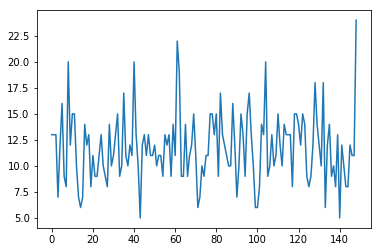

In [57]:
payday_arr = np.argmax(payday_hdpmodel.get_topics(),axis=0)
y, x = np.histogram(payday_arr, bins=np.arange(150))
fig, ax = plt.subplots()
ax.plot(x[:-1], y)
fig.show()

# Looking at the most probable topic for each complaint and then plotting a frequency distribution does not help identify the key topics from the 150 topics.

In [58]:
payday_topic_infer=payday_hdpmodel.get_topics()

In [59]:
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.percentile.html
k_high_payday=np.percentile(payday_topic_infer,75) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
k_low_payday=np.percentile(payday_topic_infer,25) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
print(k_low_payday,k_high_payday)

0.0001670632711547037 0.0007959908260125139


# The two outlier thresholds indicate values (beyond thresholds) that need to be ignored...else topic interpretability suffers as the probability of a topic due to specific compliants dominate...


In [60]:
payday_topic_infer_df=pd.DataFrame(payday_topic_infer)

In [61]:
payday_topic_infer_df

0         1         2         3         4         5         6     \
0    0.000568  0.000039  0.000280  0.000063  0.000024  0.000740  0.001397   
1    0.001243  0.000272  0.000367  0.000322  0.002668  0.000926  0.001305   
2    0.001233  0.001547  0.000403  0.000249  0.002475  0.000474  0.002371   
3    0.000359  0.001915  0.002254  0.000066  0.000545  0.000045  0.000084   
4    0.001460  0.002575  0.000926  0.000939  0.000551  0.000470  0.000413   
5    0.000738  0.000013  0.000566  0.000050  0.000731  0.000370  0.000577   
6    0.000770  0.000535  0.000087  0.000859  0.001444  0.000050  0.000487   
7    0.000894  0.000504  0.000367  0.000478  0.000513  0.002030  0.001343   
8    0.000465  0.001417  0.001470  0.001124  0.001851  0.001302  0.001286   
9    0.000807  0.000534  0.000890  0.000897  0.001309  0.000081  0.001109   
10   0.002291  0.000352  0.000100  0.000119  0.000146  0.000741  0.000818   
11   0.000161  0.001187  0.001664  0.001161  0.000029  0.000122  0.000397   
12   0.001391  0.001475  0.000072  0.000088  0.001503  0.000016  0.001363   
13   0.000064  0.000301  0.000688  0.000113  0.000508  0.000088  0.000114   
14   0.000378  0.000996  0.000408  0.000216  0.002085  0.000012  0.001426   
15   0.000343  0.001116  0.000573  0.000933  0.000397  0.000583  0.000526   
16   0.000457  0.000733  0.000535  0.000440  0.000345  0.000589  0.000366   
17   0.000471  0.001240  0.000082  0.000176  0.000247  0.000279  0.001398   
18   0.001388  0.000139  0.000227  0.000170  0.000765  0.001001  0.001868   
19   0.000219  0.000151  0.000168  0.000179  0.000860  0.000073  0.000138   
20   0.000180  0.000830  0.000443  0.001191  0.000403  0.000189  0.000165   
21   0.000068  0.000845  0.000916  0.000020  0.000029  0.000076  0.000857   
22   0.000176  0.000620  0.000857  0.000467  0.000685  0.000094  0.000101   
23   0.000849  0.000168  0.000347  0.000567  0.000221  0.000204  0.000077   
24   0.000030  0.000267  0.000384  0.000300  0.000929  0.001083  0.000354   
25   0.000967  0.000021  0.000073  0.000403  0.000471  0.000003  0.002635   
26   0.000289  0.000416  0.001610  0.000222  0.001103  0.000711  0.000425   
27   0.000046  0.000137  0.000193  0.000159  0.000512  0.000305  0.000217   
28   0.000976  0.000076  0.000006  0.000119  0.000226  0.000530  0.000379   
29   0.000492  0.000412  0.000217  0.001301  0.000136  0.000082  0.001686   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.001311  0.000560  0.000227  0.000432  0.000449  0.000327  0.001038   
121  0.001022  0.000129  0.000085  0.000178  0.003602  0.000061  0.000496   
122  0.000076  0.001447  0.000048  0.000411  0.000635  0.001811  0.000143   
123  0.000802  0.000602  0.000029  0.001450  0.000450  0.001402  0.000594   
124  0.000501  0.001383  0.000858  0.000030  0.000801  0.000074  0.000972   
125  0.003156  0.000012  0.000616  0.000249  0.000380  0.000321  0.000536   
126  0.000054  0.000306  0.001234  0.000103  0.000132  0.000115  0.000154   
127  0.001176  0.000560  0.000111  0.000041  0.000258  0.000339  0.000611   
128  0.001614  0.000390  0.000042  0.001553  0.000754  0.000189  0.000895   
129  0.000005  0.000296  0.000280  0.000345  0.001459  0.000102  0.000668   
130  0.000326  0.000210  0.000262  0.000070  0.000030  0.000347  0.001950   
131  0.001038  0.000071  0.001444  0.000303  0.000158  0.000135  0.000688   
132  0.001010  0.000127  0.000704  0.000472  0.001203  0.000905  0.000720   
133  0.000337  0.000363  0.000102  0.000303  0.000690  0.000621  0.000031   
134  0.000899  0.000430  0.000397  0.002498  0.001179  0.001115  0.000396   
135  0.003672  0.000856  0.001378  0.000672  0.001021  0.001247  0.000443   
136  0.000518  0.001264  0.000198  0.000065  0.000323  0.000278  0.000290   
137  0.000725  0.001314  0.000525  0.000810  0.000047  0.000218  0.000311   
138  0.000844  0.000334  0.000184  0.001371  0.001335  0.000399  0.000847   
139  0.000339  0.000184  0.001106  0.000358  0.001708  0.000323  0.000217   
140  

In [62]:
#https://stackoverflow.com/questions/43757977/replacing-values-greater-than-a-number-in-pandas-dataframe
payday_topic_infer_filter_df=payday_topic_infer_df.apply(lambda x: [y if (y > k_low_payday and y < k_high_payday) else 0 for y in x])

In [63]:
payday_topic_infer_filter_df

0         1         2         3         4         5         6     \
0    0.000568  0.000000  0.000280  0.000000  0.000000  0.000740  0.000000   
1    0.000000  0.000272  0.000367  0.000322  0.000000  0.000000  0.000000   
2    0.000000  0.000000  0.000403  0.000249  0.000000  0.000474  0.000000   
3    0.000359  0.000000  0.000000  0.000000  0.000545  0.000000  0.000000   
4    0.000000  0.000000  0.000000  0.000000  0.000551  0.000470  0.000413   
5    0.000738  0.000000  0.000566  0.000000  0.000731  0.000370  0.000577   
6    0.000770  0.000535  0.000000  0.000000  0.000000  0.000000  0.000487   
7    0.000000  0.000504  0.000367  0.000478  0.000513  0.000000  0.000000   
8    0.000465  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9    0.000000  0.000534  0.000000  0.000000  0.000000  0.000000  0.000000   
10   0.000000  0.000352  0.000000  0.000000  0.000000  0.000741  0.000000   
11   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000397   
12   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13   0.000000  0.000301  0.000688  0.000000  0.000508  0.000000  0.000000   
14   0.000378  0.000000  0.000408  0.000216  0.000000  0.000000  0.000000   
15   0.000343  0.000000  0.000573  0.000000  0.000397  0.000583  0.000526   
16   0.000457  0.000733  0.000535  0.000440  0.000345  0.000589  0.000366   
17   0.000471  0.000000  0.000000  0.000176  0.000247  0.000279  0.000000   
18   0.000000  0.000000  0.000227  0.000170  0.000765  0.000000  0.000000   
19   0.000219  0.000000  0.000168  0.000179  0.000000  0.000000  0.000000   
20   0.000180  0.000000  0.000443  0.000000  0.000403  0.000189  0.000000   
21   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22   0.000176  0.000620  0.000000  0.000467  0.000685  0.000000  0.000000   
23   0.000000  0.000168  0.000347  0.000567  0.000221  0.000204  0.000000   
24   0.000000  0.000267  0.000384  0.000300  0.000000  0.000000  0.000354   
25   0.000000  0.000000  0.000000  0.000403  0.000471  0.000000  0.000000   
26   0.000289  0.000416  0.000000  0.000222  0.000000  0.000711  0.000425   
27   0.000000  0.000000  0.000193  0.000000  0.000512  0.000305  0.000217   
28   0.000000  0.000000  0.000000  0.000000  0.000226  0.000530  0.000379   
29   0.000492  0.000412  0.000217  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.000000  0.000560  0.000227  0.000432  0.000449  0.000327  0.000000   
121  0.000000  0.000000  0.000000  0.000178  0.000000  0.000000  0.000496   
122  0.000000  0.000000  0.000000  0.000411  0.000635  0.000000  0.000000   
123  0.000000  0.000602  0.000000  0.000000  0.000450  0.000000  0.000594   
124  0.000501  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
125  0.000000  0.000000  0.000616  0.000249  0.000380  0.000321  0.000536   
126  0.000000  0.000306  0.000000  0.000000  0.000000  0.000000  0.000000   
127  0.000000  0.000560  0.000000  0.000000  0.000258  0.000339  0.000611   
128  0.000000  0.000390  0.000000  0.000000  0.000754  0.000189  0.000000   
129  0.000000  0.000296  0.000280  0.000345  0.000000  0.000000  0.000668   
130  0.000326  0.000210  0.000262  0.000000  0.000000  0.000347  0.000000   
131  0.000000  0.000000  0.000000  0.000303  0.000000  0.000000  0.000688   
132  0.000000  0.000000  0.000704  0.000472  0.000000  0.000000  0.000720   
133  0.000337  0.000363  0.000000  0.000303  0.000690  0.000621  0.000000   
134  0.000000  0.000430  0.000397  0.000000  0.000000  0.000000  0.000396   
135  0.000000  0.000000  0.000000  0.000672  0.000000  0.000000  0.000443   
136  0.000518  0.000000  0.000198  0.000000  0.000323  0.000278  0.000290   
137  0.000725  0.000000  0.000525  0.000000  0.000000  0.000218  0.000311   
138  0.000000  0.000334  0.000184  0.000000  0.000000  0.000399  0.000000   
139  0.000339  0.000184  0.000000  0.000358  0.000000  0.000323  0.000217   
140  

In [64]:
payday_topic_infer_filter_df.median(axis=1).sort_values()

74     0.000000
93     0.000000
53     0.000000
52     0.000000
51     0.000000
96     0.000000
98     0.000000
47     0.000000
46     0.000000
45     0.000000
44     0.000000
99     0.000000
42     0.000000
41     0.000000
101    0.000000
102    0.000000
56     0.000000
78     0.000000
91     0.000000
59     0.000000
75     0.000000
148    0.000000
73     0.000000
72     0.000000
71     0.000000
81     0.000000
83     0.000000
86     0.000000
89     0.000000
66     0.000000
         ...   
18     0.000175
140    0.000175
84     0.000175
68     0.000176
105    0.000176
114    0.000176
27     0.000176
30     0.000176
107    0.000177
6      0.000177
97     0.000177
79     0.000177
11     0.000178
95     0.000178
9      0.000178
80     0.000178
100    0.000179
130    0.000179
82     0.000180
40     0.000180
33     0.000180
57     0.000180
4      0.000181
141    0.000181
85     0.000183
119    0.000183
24     0.000184
104    0.000184
120    0.000184
12     0.000188
Length: 150, dtype: floa

In [65]:
payday_topic_infer_filter_df.median(axis=1).sort_values().sum()

0.01357333182667429

# Filter applied above!

In [66]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#https://stackoverflow.com/questions/3940128/how-can-i-reverse-a-list-in-python
payday_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]

[12, 120, 104, 24, 119, 85, 141, 4, 57, 33]

# Only the median probabilty of a topic across all complaints ---after filter step---is considered for ranking the topics.

In [67]:
relevant_top10_payday_topic=payday_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]
#print(relevant_top10_payday_topic)

In [68]:
for relevant_topic_id in relevant_top10_payday_topic:
    print(payday_hdpmodel.show_topics(num_topics=150,num_words=7)[relevant_topic_id])

(12, '0.004*turbulence + 0.003*investigation + 0.003*snd + 0.003*case + 0.003*officer + 0.003*a + 0.003*mail')
(120, '0.006*involvement + 0.005*communication + 0.004*www + 0.004*overdue + 0.004*assistance + 0.004*disruption + 0.003*harrassment')
(104, '0.004*email + 0.004*flexibility + 0.004*bureaus + 0.004*engage + 0.003*regarding + 0.003*timeline + 0.003*snooping')
(24, '0.004*roommate + 0.004*larceny + 0.003*prey + 0.003*appointment + 0.003*teller + 0.003*express + 0.003*coercion')
(119, '0.005*relief + 0.004*collo + 0.004*buiness + 0.004*writing + 0.004*notice + 0.003*widow + 0.003*seeking')
(85, '0.004*shot + 0.004*homestead + 0.003*counselor + 0.003*email + 0.003*violation + 0.003*improvement + 0.003*step')
(141, '0.004*heat + 0.004*fault + 0.004*839,i + 0.003*work + 0.003*checking + 0.003*advertisement + 0.003*clerk')
(4, '0.005*load + 0.004*breech + 0.004*monitoring + 0.004*boot + 0.004*laon + 0.003*processing + 0.003*ace')
(57, '0.003*need + 0.003*mo + 0.003*search + 0.003*reg

# Draft Interpretation of 10 Payday Loan topics


(12, '0.004*turbulence + 0.003*investigation + 0.003*snd + 0.003*case + 0.003*officer + 0.003*a + 0.003*mail')

Topic 12: Eligibility assessment unsatisfactory.

(120, '0.006*involvement + 0.005*communication + 0.004*www + 0.004*overdue + 0.004*assistance + 0.004*disruption + 0.003*harrassment')

Topic 120: Harassed for overdue payments.

(104, '0.004*email + 0.004*flexibility + 0.004*bureaus + 0.004*engage + 0.003*regarding + 0.003*timeline + 0.003*snooping')

Topic 104: Seeking protection from intimidation by collection agencies.

(24, '0.004*roommate + 0.004*larceny + 0.003*prey + 0.003*appointment + 0.003*teller + 0.003*express + 0.003*coercion')

Topic 24: Mis-selling of loan.

(119, '0.005*relief + 0.004*collo + 0.004*buiness + 0.004*writing + 0.004*notice + 0.003*widow + 0.003*seeking')

Topic 119: Seeking modification of loan due to personal emergency.


(85, '0.004*shot + 0.004*homestead + 0.003*counselor + 0.003*email + 0.003*violation + 0.003*improvement + 0.003*step')

Topic 85: Seeking help for new repayment plan.

(141, '0.004*heat + 0.004*fault + 0.004*839,i + 0.003*work + 0.003*checking + 0.003*advertisement + 0.003*clerk')

Topic 141: Fraudulent advertisement.

(4, '0.005*load + 0.004*breech + 0.004*monitoring + 0.004*boot + 0.004*laon + 0.003*processing + 0.003*ace')

Topic 4: <Not interpretable?>

(57, '0.003*need + 0.003*mo + 0.003*search + 0.003*regard + 0.003*loanme + 0.003*+ + 0.003*initiation')

Topic 57: <Not interpretable?>


(33, '0.004*opposite + 0.004*midwest + 0.004*job + 0.003*letter + 0.003*story + 0.003*legitimacy + 0.003*ideal')

Topic 33: Need repayment plan because of unemployment.


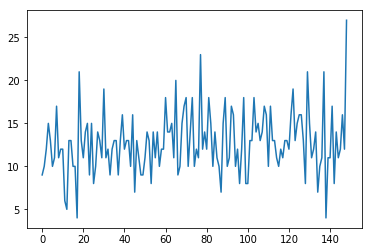

In [69]:
student_arr = np.argmax(student_hdpmodel.get_topics(),axis=0)
y, x = np.histogram(student_arr, bins=np.arange(150))
fig, ax = plt.subplots()
ax.plot(x[:-1], y)
fig.show()

# Looking at the most probable topic for each complaint and then plotting a frequency distribution does not help identify the key 10 topics from the 150 topics??

In [70]:
student_topic_infer=student_hdpmodel.get_topics()

In [71]:
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.percentile.html
k_high_student=np.percentile(student_topic_infer,75) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
k_low_student=np.percentile(student_topic_infer,25) #experimented with 90 and 10...topic interpretability drops; 80, 10 is inferior
print(k_low_student,k_high_student)

0.00015293148152146227 0.0007304912847943994


# The two outlier thresholds indicate values (beyond thresholds) that need to be ignored...else topic interpretability suffers as the probability of a topic due to specific compliants dominate...


In [72]:
student_topic_infer_df=pd.DataFrame(student_topic_infer)

In [73]:
student_topic_infer_df

0         1         2         3         4         5         6     \
0    0.000159  0.001649  0.000102  0.001025  0.000026  0.000872  0.000378   
1    0.000578  0.000900  0.000264  0.000157  0.000039  0.001377  0.001097   
2    0.000687  0.001688  0.000246  0.000016  0.000785  0.000550  0.000699   
3    0.000174  0.000191  0.000374  0.000086  0.000316  0.000354  0.000198   
4    0.000086  0.000251  0.000139  0.000809  0.000112  0.000367  0.001392   
5    0.000333  0.000051  0.000414  0.001743  0.000649  0.000354  0.001581   
6    0.002430  0.000431  0.000244  0.000346  0.001442  0.000495  0.000125   
7    0.001724  0.001139  0.000551  0.000604  0.000124  0.000107  0.000618   
8    0.000747  0.000762  0.000534  0.000392  0.000416  0.000659  0.000523   
9    0.000566  0.000370  0.001068  0.000902  0.000206  0.000399  0.000410   
10   0.000025  0.000232  0.001112  0.000003  0.000497  0.000127  0.001795   
11   0.001383  0.000215  0.000604  0.000579  0.000156  0.001577  0.000534   
12   0.000203  0.000528  0.000145  0.000325  0.000068  0.000989  0.000750   
13   0.000181  0.000701  0.000307  0.000227  0.000532  0.000315  0.000202   
14   0.000109  0.000502  0.000042  0.000358  0.000116  0.000668  0.000526   
15   0.000394  0.000372  0.001133  0.000175  0.000414  0.000492  0.000515   
16   0.000491  0.000323  0.000610  0.000434  0.000457  0.000578  0.000621   
17   0.000592  0.002182  0.000946  0.000433  0.000481  0.000596  0.000225   
18   0.000624  0.001857  0.000644  0.000679  0.001097  0.000100  0.000039   
19   0.000599  0.000124  0.000223  0.000252  0.000680  0.000041  0.000296   
20   0.000327  0.000721  0.000120  0.000220  0.000063  0.000314  0.000020   
21   0.000099  0.000014  0.000156  0.001480  0.001076  0.000104  0.000010   
22   0.000167  0.000999  0.001717  0.001825  0.001174  0.000277  0.000355   
23   0.000436  0.000662  0.000469  0.000433  0.000285  0.000534  0.000321   
24   0.000425  0.000505  0.000559  0.000357  0.000381  0.002305  0.000732   
25   0.000281  0.000379  0.000070  0.000438  0.000568  0.000252  0.000047   
26   0.000414  0.000732  0.000474  0.000276  0.000349  0.000145  0.000643   
27   0.000375  0.000754  0.001079  0.000566  0.000282  0.000322  0.000444   
28   0.000630  0.000514  0.000853  0.000049  0.000433  0.000159  0.000580   
29   0.000419  0.001657  0.000693  0.000630  0.000207  0.000051  0.001473   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.000381  0.000398  0.000086  0.000286  0.000016  0.000195  0.001015   
121  0.000104  0.000307  0.000047  0.001115  0.000895  0.000163  0.000582   
122  0.000163  0.000379  0.000293  0.000346  0.000017  0.000536  0.000329   
123  0.000124  0.000093  0.000089  0.000266  0.000077  0.001388  0.000796   
124  0.000202  0.000006  0.000025  0.000208  0.000434  0.000045  0.000125   
125  0.001191  0.000003  0.000833  0.000372  0.000642  0.000357  0.000004   
126  0.000773  0.001005  0.000300  0.000042  0.000253  0.000323  0.000690   
127  0.000040  0.000255  0.001253  0.000178  0.001149  0.000294  0.000997   
128  0.000506  0.000440  0.000180  0.000280  0.000194  0.000291  0.000015   
129  0.000383  0.001044  0.001792  0.000337  0.000475  0.000183  0.000378   
130  0.001338  0.000718  0.000658  0.000985  0.000370  0.000721  0.000267   
131  0.000032  0.000738  0.000039  0.000261  0.000955  0.000292  0.000376   
132  0.000207  0.000868  0.000099  0.000035  0.000887  0.000137  0.000457   
133  0.000757  0.001500  0.000415  0.000186  0.000232  0.000008  0.000174   
134  0.000898  0.000080  0.000039  0.000114  0.000739  0.000062  0.000105   
135  0.000373  0.000046  0.000243  0.000312  0.001857  0.000108  0.000757   
136  0.002126  0.000359  0.000394  0.000020  0.000893  0.000870  0.000066   
137  0.001688  0.000031  0.000340  0.000161  0.000305  0.000748  0.000634   
138  0.001734  0.000802  0.000302  0.000263  0.000458  0.000360  0.000258   
139  0.000250  0.000148  0.000680  0.001042  0.000375  0.000202  0.000489   
140  

In [74]:
#https://stackoverflow.com/questions/43757977/replacing-values-greater-than-a-number-in-pandas-dataframe
student_topic_infer_filter_df=student_topic_infer_df.apply(lambda x: [y if (y > k_low_student and y < k_high_student) else 0 for y in x])


In [75]:
student_topic_infer_filter_df

0         1         2         3         4         5         6     \
0    0.000159  0.000000  0.000000  0.000000  0.000000  0.000000  0.000378   
1    0.000578  0.000000  0.000264  0.000157  0.000000  0.000000  0.000000   
2    0.000687  0.000000  0.000246  0.000000  0.000000  0.000550  0.000699   
3    0.000174  0.000191  0.000374  0.000000  0.000316  0.000354  0.000198   
4    0.000000  0.000251  0.000000  0.000000  0.000000  0.000367  0.000000   
5    0.000333  0.000000  0.000414  0.000000  0.000649  0.000354  0.000000   
6    0.000000  0.000431  0.000244  0.000346  0.000000  0.000495  0.000000   
7    0.000000  0.000000  0.000551  0.000604  0.000000  0.000000  0.000618   
8    0.000000  0.000000  0.000534  0.000392  0.000416  0.000659  0.000523   
9    0.000566  0.000370  0.000000  0.000000  0.000206  0.000399  0.000410   
10   0.000000  0.000232  0.000000  0.000000  0.000497  0.000000  0.000000   
11   0.000000  0.000215  0.000604  0.000579  0.000156  0.000000  0.000534   
12   0.000203  0.000528  0.000000  0.000325  0.000000  0.000000  0.000000   
13   0.000181  0.000701  0.000307  0.000227  0.000532  0.000315  0.000202   
14   0.000000  0.000502  0.000000  0.000358  0.000000  0.000668  0.000526   
15   0.000394  0.000372  0.000000  0.000175  0.000414  0.000492  0.000515   
16   0.000491  0.000323  0.000610  0.000434  0.000457  0.000578  0.000621   
17   0.000592  0.000000  0.000000  0.000433  0.000481  0.000596  0.000225   
18   0.000624  0.000000  0.000644  0.000679  0.000000  0.000000  0.000000   
19   0.000599  0.000000  0.000223  0.000252  0.000680  0.000000  0.000296   
20   0.000327  0.000721  0.000000  0.000220  0.000000  0.000314  0.000000   
21   0.000000  0.000000  0.000156  0.000000  0.000000  0.000000  0.000000   
22   0.000167  0.000000  0.000000  0.000000  0.000000  0.000277  0.000355   
23   0.000436  0.000662  0.000469  0.000433  0.000285  0.000534  0.000321   
24   0.000425  0.000505  0.000559  0.000357  0.000381  0.000000  0.000000   
25   0.000281  0.000379  0.000000  0.000438  0.000568  0.000252  0.000000   
26   0.000414  0.000000  0.000474  0.000276  0.000349  0.000000  0.000643   
27   0.000375  0.000000  0.000000  0.000566  0.000282  0.000322  0.000444   
28   0.000630  0.000514  0.000000  0.000000  0.000433  0.000159  0.000580   
29   0.000419  0.000000  0.000693  0.000630  0.000207  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
120  0.000381  0.000398  0.000000  0.000286  0.000000  0.000195  0.000000   
121  0.000000  0.000307  0.000000  0.000000  0.000000  0.000163  0.000582   
122  0.000163  0.000379  0.000293  0.000346  0.000000  0.000536  0.000329   
123  0.000000  0.000000  0.000000  0.000266  0.000000  0.000000  0.000000   
124  0.000202  0.000000  0.000000  0.000208  0.000434  0.000000  0.000000   
125  0.000000  0.000000  0.000000  0.000372  0.000642  0.000357  0.000000   
126  0.000000  0.000000  0.000300  0.000000  0.000253  0.000323  0.000690   
127  0.000000  0.000255  0.000000  0.000178  0.000000  0.000294  0.000000   
128  0.000506  0.000440  0.000180  0.000280  0.000194  0.000291  0.000000   
129  0.000383  0.000000  0.000000  0.000337  0.000475  0.000183  0.000378   
130  0.000000  0.000718  0.000658  0.000000  0.000370  0.000721  0.000267   
131  0.000000  0.000000  0.000000  0.000261  0.000000  0.000292  0.000376   
132  0.000207  0.000000  0.000000  0.000000  0.000000  0.000000  0.000457   
133  0.000000  0.000000  0.000415  0.000186  0.000232  0.000000  0.000174   
134  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
135  0.000373  0.000000  0.000243  0.000312  0.000000  0.000000  0.000000   
136  0.000000  0.000359  0.000394  0.000000  0.000000  0.000000  0.000000   
137  0.000000  0.000000  0.000340  0.000161  0.000305  0.000000  0.000634   
138  0.000000  0.000000  0.000302  0.000263  0.000458  0.000360  0.000258   
139  0.000250  0.000000  0.000680  0.000000  0.000375  0.000202  0.000489   
140  

In [76]:
student_topic_infer_filter_df.median(axis=1).sort_values()

74     0.000000
66     0.000000
64     0.000000
110    0.000000
61     0.000000
112    0.000000
59     0.000000
57     0.000000
67     0.000000
55     0.000000
52     0.000000
113    0.000000
114    0.000000
115    0.000000
96     0.000000
45     0.000000
44     0.000000
53     0.000000
68     0.000000
70     0.000000
108    0.000000
92     0.000000
91     0.000000
90     0.000000
89     0.000000
88     0.000000
87     0.000000
86     0.000000
98     0.000000
82     0.000000
         ...   
9      0.000160
33     0.000160
121    0.000160
19     0.000160
71     0.000161
69     0.000161
72     0.000161
83     0.000161
42     0.000161
34     0.000161
80     0.000162
145    0.000162
49     0.000162
129    0.000163
25     0.000163
81     0.000163
12     0.000163
11     0.000164
60     0.000164
132    0.000165
31     0.000165
139    0.000166
140    0.000166
2      0.000166
116    0.000167
22     0.000167
104    0.000167
123    0.000168
126    0.000173
0      0.000180
Length: 150, dtype: floa

In [77]:
student_topic_infer_filter_df.median(axis=1).sort_values().sum()

0.011808059507300126

# Filter applied above!

In [78]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#https://stackoverflow.com/questions/3940128/how-can-i-reverse-a-list-in-python
student_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]

[0, 126, 123, 104, 22, 116, 2, 140, 139, 31]

# Only the median probabilty of a topic across all complaints ---after filter step---is considered for ranking the topics.


In [79]:
relevant_top10_student_topic=student_topic_infer_filter_df.median(axis=1).sort_values().index[-10:].values.tolist()[::-1]
#print(relevant_top10_student_topic)

In [80]:
for relevant_topic_id in relevant_top10_student_topic:
    print(student_hdpmodel.show_topics(num_topics=150,num_words=7)[relevant_topic_id])

(0, '0.004*track + 0.003*school + 0.003*way + 0.003*wage + 0.003*transportation + 0.003*hospitalization + 0.003*police')
(126, '0.004*urgency + 0.004*dream + 0.004*achievement + 0.004*pattern + 0.003*witness + 0.003*ruling + 0.003*-discussion')
(123, '0.004*purgatory + 0.003*difference + 0.003*life + 0.003*litigation + 0.003*reapplication + 0.003*jewelry + 0.003*fall')
(104, '0.004*dial + 0.003*entity + 0.003*reconciliation + 0.003*assurance + 0.003*rip + 0.003*leaf + 0.003*sender')
(22, '0.005*center + 0.004*fore + 0.004*formula + 0.003*spousal + 0.003*coborrower + 0.003*everyday + 0.003*counter')
(116, '0.004*sic + 0.003*showcase + 0.003*nelnet + 0.003*aid + 0.003*well + 0.003*party + 0.003*burial')
(2, '0.004*hit + 0.004*balance + 0.003*program + 0.003*bubble + 0.003*research + 0.003*year + 0.003*negotiation')
(140, '0.004*acknowledgement + 0.004*student + 0.003*jersey + 0.003*recipient + 0.003*prepayment + 0.003*assignment + 0.003*dot')
(139, '0.005*college + 0.004*brochure + 0.004

# Draft Interpretation of 10 Student Loan topics

(0, '0.004*track + 0.003*school + 0.003*way + 0.003*wage + 0.003*transportation + 0.003*hospitalization + 0.003*police')

Topic 0: Seeking accommodation for personal problems.

(126, '0.004*urgency + 0.004*dream + 0.004*achievement + 0.004*pattern + 0.003*witness + 0.003*ruling + 0.003*-discussion')

Topic 126: Want to resolve by court proceedings or by discussion.


(123, '0.004*purgatory + 0.003*difference + 0.003*life + 0.003*litigation + 0.003*reapplication + 0.003*jewelry + 0.003*fall')
(104, '0.004*dial + 0.003*entity + 0.003*reconciliation + 0.003*assurance + 0.003*rip + 0.003*leaf + 0.003*sender')

Topic 123: Despite best efforts failed in my application for modification.


(22, '0.005*center + 0.004*fore + 0.004*formula + 0.003*spousal + 0.003*coborrower + 0.003*everyday + 0.003*counter')
(116, '0.004*sic + 0.003*showcase + 0.003*nelnet + 0.003*aid + 0.003*well + 0.003*party + 0.003*burial')

Topic 22: Seek accommodation because co-borrower passed away.


(2, '0.004*hit + 0.004*balance + 0.003*program + 0.003*bubble + 0.003*research + 0.003*year + 0.003*negotiation')

Topic 2: Want to apply for a program to modify my loan.


(140, '0.004*acknowledgement + 0.004*student + 0.003*jersey + 0.003*recipient + 0.003*prepayment + 0.003*assignment + 0.003*dot')

Topic 140: Problems in making prepayment.


(139, '0.005*college + 0.004*brochure + 0.004*society + 0.004*corruption + 0.004*order + 0.003*misinformation + 0.003*month')

Topic 139: Mis-selling of loan.


(31, '0.004*college + 0.003*reapplication + 0.003*validation + 0.003*frame + 0.003*click + 0.003*format + 0.003*government')

Topic 31: Problems with my application.



In [790]:
#https://stackoverflow.com/questions/17354417/gensim-how-to-save-lda-models-produced-topics-to-a-readable-format-csv-txt-et
payday_hdpmodel.save('payday_hdpmodel')
student_hdpmodel.save('student_hdpmodel')
mortgage_hdpmodel.save('mortgage_hdpmodel')

In [792]:
dfmortproddebtcoll_common_cos.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [801]:
dfmortproddebtcoll_common_cos['Date received']=pd.to_datetime(dfmortproddebtcoll_common_cos['Date received'])

In [793]:
dfpayproddebtcoll_common_cos.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [802]:
dfpayproddebtcoll_common_cos['Date received']=pd.to_datetime(dfpayproddebtcoll_common_cos['Date received'])

In [794]:
dfstudproddebtcoll_common_cos.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [803]:
dfstudproddebtcoll_common_cos['Date received']=pd.to_datetime(dfstudproddebtcoll_common_cos['Date received'])

In [807]:
dfmortproddebtcoll_common_cos.to_pickle('dfmortproddebtcoll_common_cos.pickle')
dfpayproddebtcoll_common_cos.to_pickle('dfpayproddebtcoll_common_cos.pickle')
dfstudproddebtcoll_common_cos.to_pickle('dfstudproddebtcoll_common_cos.pickle')

In [809]:
#https://stackoverflow.com/questions/4530611/saving-and-loading-objects-and-using-pickle
import pickle

payday_filehandler = open('payday_dictionary.pickle','wb')
pickle.dump(payday_dictionary,payday_filehandler)
payday_filehandler.close()

student_filehandler = open('student_dictionary.pickle','wb')
pickle.dump(student_dictionary,student_filehandler)
student_filehandler.close()

mortgage_filehandler = open('mortgage_dictionary.pickle','wb')
pickle.dump(mortgage_dictionary,mortgage_filehandler)
mortgage_filehandler.close()